In [1]:
"""
Python script to scrape Friktion User Data from Bitquery GraphQL API.

"""

import json
import requests
import requests
import traceback
import time

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from os.path import exists

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [223]:
"""
Plotting Formatters
"""

from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


formatter = FuncFormatter(millions)

def percents(x, pos):
    'The two args are the value and tick position'
    return "{:.0%}".format(x)


formatter_percents = FuncFormatter(percents)

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

In [69]:
"""
Get current Coingecko prices for analysis
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import json
import ccxt

import datetime

cftx = ccxt.ftx(
    {
        "apiKey":"mvnd3WRG56rAP-6MpxFyZ5sN2WnjEO8UsQB6u-6s",
        "secret":"m_m926E36IMlrhCv6bGkLdSdaVegbm5PggpCrFCM"
    }
)

markets = cftx.load_markets()
binance = ccxt.binance()

# 10 days
time_since = datetime.datetime.timestamp(datetime.datetime.now())*1000-100000

symbols = {
    "BTC": "BTC/USD", 
    "ETH": "ETH/USD", 
    "SOL": "SOL/USD", 
    "MSOL": "MSOL/USD", 
    "LUNA": "LUNA/USD:USD", 
    "FTT": "FTT/USD", 
    "SRM": "SRM/USD",
    "MNGO": "MNGO/USD",
    "RAY": "RAY/USD", 
    "STEP": "STEP/USD",
    "AVAX": "AVAX/USD"
}
pricedf = {}
for k, symbol in symbols.items():
    data = cftx.fetchOHLCV(symbol, '1m', since=time_since, limit=1)
    tree = pd.DataFrame(data, columns=["time", "open", "high", "low", "close", "volume"])
    data
    print(data)
    pricedf[k] = tree["close"]
    

# Random price hardcodes b/c they aren't traded on FTX

pricedf["USDC"] =pricedf["tsUSDC"] = pricedf["UST"] = 1
pricedf["mSOL"] = pricedf["SOL"]*1.03
pricedf["scnSOL"] = pricedf["SOL"]*1.03
pricedf["SBR"] = 0.04000

tree = pd.DataFrame(pricedf).T.reset_index()
tree.columns = ["symbol", "price"]


[[1648875600000, 46551.0, 46553.0, 46513.0, 46520.0, 230482.9798]]
[[1648875600000, 3480.3, 3480.6, 3477.1, 3477.2, 106409.5881]]
[[1648875600000, 135.17, 135.3025, 135.0325, 135.1125, 38745.7737]]
[[1648875600000, 139.95, 140.25, 139.825, 139.825, 0.0]]
[[1648875600000, 107.755, 107.82, 107.743, 107.764, 105955.9678]]
[[1648875600000, 50.592, 50.594, 50.534, 50.548, 19834.3776]]
[[1648875600000, 3.402, 3.403, 3.397, 3.398, 2161.992]]
[[1648875600000, 0.170225, 0.170225, 0.170225, 0.170225, 0.0]]
[[1648875600000, 3.6715, 3.6725, 3.6657, 3.6669, 8594.1402]]
[[1648875600000, 0.2185, 0.219, 0.2185, 0.219, 0.0219]]
[[1648875600000, 98.063, 98.093, 97.909, 97.956, 4223.8407]]


In [70]:
pricedf

{'BTC': 0    46520.0
 Name: close, dtype: float64,
 'ETH': 0    3477.2
 Name: close, dtype: float64,
 'SOL': 0    135.1125
 Name: close, dtype: float64,
 'MSOL': 0    139.825
 Name: close, dtype: float64,
 'LUNA': 0    107.764
 Name: close, dtype: float64,
 'FTT': 0    50.548
 Name: close, dtype: float64,
 'SRM': 0    3.398
 Name: close, dtype: float64,
 'MNGO': 0    0.170225
 Name: close, dtype: float64,
 'RAY': 0    3.6669
 Name: close, dtype: float64,
 'STEP': 0    0.219
 Name: close, dtype: float64,
 'AVAX': 0    97.956
 Name: close, dtype: float64,
 'USDC': 1,
 'tsUSDC': 1,
 'UST': 1,
 'mSOL': 0    139.165875
 Name: close, dtype: float64,
 'scnSOL': 0    139.165875
 Name: close, dtype: float64,
 'SBR': 0.04}

In [286]:
# Read Data

deposits = pd.read_csv("friktion_deposit.csv")
withdrawals = pd.read_csv("friktion_withdraw.csv")
claim = pd.read_csv("friktion_claim_withdrawal.csv")
withdrawals_cxl = pd.read_csv("friktion_withdraw_cancel.csv")
deposits_cxl = pd.read_csv("friktion_deposit_cxl.csv")

df_all = pd.concat([withdrawals, claim, withdrawals_cxl, deposits_cxl, deposits], ignore_index=False).reset_index(drop=True)

df_all = pd.merge(df_all, tree, left_on="depositTokenSymbol", right_on="symbol", how='left')

df_all["amount_usdc"] = df_all["amount"]*df_all["price"]

In [287]:
def calculate_tvl_change(x):
    mult = 0
    if x["userAction"] in ["Deposit", "CancelPendingWithdrawal"]:
        mult = 1
    elif x["userAction"] in ["CancelPendingDeposit", "Withdraw"]:
        mult = -1

    return x["amount_usdc"]*mult

df_all.apply(lambda x: calculate_tvl_change(x), axis=1)

df_all["net_tvl"] = df_all.apply(lambda x: calculate_tvl_change(x), axis=1)
tvl = df_all.groupby('timestamp')["net_tvl"].sum().cumsum()

tvl = df_all.loc[df_all.userAction!="ClaimPendingWithdrawal"]

tvl = tvl.reset_index(drop=True)

In [288]:
# Cohort Analysis. Epoch ends at Thursday 8am UTC 

first_epoch = datetime.datetime(2021, 12, 17, 2)

tvl["epoch"] = ((pd.to_datetime(tvl.timestamp).dt.tz_localize(None)-first_epoch).dt.days/7).astype('int')+1

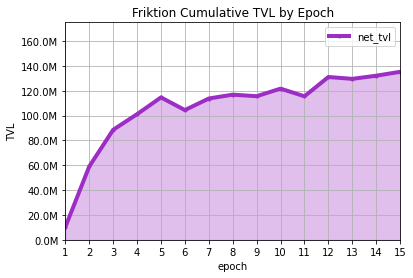

In [289]:
ax = plt.figure().gca()
cumtvl = tvl.groupby("epoch")[["net_tvl"]].sum().cumsum()
cumtvl.plot(grid=True, marker='.', ax=ax, color=CB91_Purple, linewidth=4)
ax.set_xticks(tvl.epoch.unique())

ax.yaxis.set_major_formatter(formatter)

ax.set_ylabel("TVL")
ax.set_title("Friktion Cumulative TVL by Epoch")
ax.set_ylim([0, 1.75e8])
ax.set_xlim([1, 15])
ax.fill_between(cumtvl.net_tvl.index, cumtvl.net_tvl, color=CB91_Purple, alpha=0.3)

In [290]:
tvl["globalId"] = tvl.globalId.fillna(False)

In [291]:
tvl.loc[tvl.globalId.str.contains("circuits").fillna(False)].userAddress.unique()

array(['CkbxaunPif9H3Zq24nyY87pKUe64GRteciPL5qXLUdzC',
       'WabxR2gcdMgovS6Uo5JD4Cv9me7uExRyaH4QDKrp64b',
       '3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs',
       'DWdU29KENzq87G1cm35XZTZpbBCvyNiTEiSpJgV1CWAf',
       'DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE'], dtype=object)

In [292]:
DAO_WALLETS = [
    'CkbxaunPif9H3Zq24nyY87pKUe64GRteciPL5qXLUdzC',
   'WabxR2gcdMgovS6Uo5JD4Cv9me7uExRyaH4QDKrp64b',
   '3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs',
   'DWdU29KENzq87G1cm35XZTZpbBCvyNiTEiSpJgV1CWAf',
]

In [345]:
retail = tvl.loc[~tvl.userAddress.isin(DAO_WALLETS)]

In [346]:
retail = retail.loc[retail.net_tvl.abs()>10]

In [347]:
insti = tvl.loc[tvl.userAddress.isin(DAO_WALLETS)]

# ALL

In [348]:
tvl["depositEpoch"] = tvl.groupby("userAddress")["epoch"].transform(lambda x: x.min())

cohorts = tvl.groupby(["depositEpoch", "epoch"])[["net_tvl"]].sum().groupby("depositEpoch").cumsum()

normalize = pd.Series(cohorts.groupby("depositEpoch").net_tvl.first(), name="Initial Deposit")

cohorts_final = cohorts.join(normalize)

cohorts_final["retention"] = cohorts_final["net_tvl"]/cohorts_final["Initial Deposit"]

In [349]:
cohorts_final.unstack(1)["retention"]

epoch,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
depositEpoch,,,,,,,,,,,,,,,
1,1.0,1.345179,2.086224,2.061413,2.076579,1.935369,1.581561,1.438426,1.278176,1.515492,1.503779,1.479295,1.423518,1.480475,1.320570
2,NaN,1.000000,0.991297,1.002822,1.100901,0.911119,0.888381,0.881968,0.879666,0.892819,0.838474,0.931884,0.935047,0.927296,0.911220
3,NaN,NaN,1.000000,1.247640,1.232370,1.077361,0.955552,0.872250,0.840001,0.848065,0.820822,0.801412,0.790543,0.782114,0.829737
4,NaN,NaN,NaN,1.000000,0.986320,1.112127,3.252260,3.187130,3.172164,3.415307,2.916873,3.042376,3.001524,3.014061,3.315640
5,NaN,NaN,NaN,NaN,1.000000,0.969887,0.912088,0.832803,0.758513,0.779074,0.721465,0.701593,0.712615,0.667529,0.644311
6,NaN,NaN,NaN,NaN,NaN,1.000000,1.114980,1.082551,1.117692,1.101739,1.095861,0.964984,0.978992,0.896563,0.849555
7,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.226192,1.174053,1.057230,0.988490,0.837263,0.768504,0.742789,0.692191
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.021154,0.910388,0.943548,0.963675,0.554068,0.580411,0.578139
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.127557,1.126385,1.187479,1.673953,0.685360,0.626485


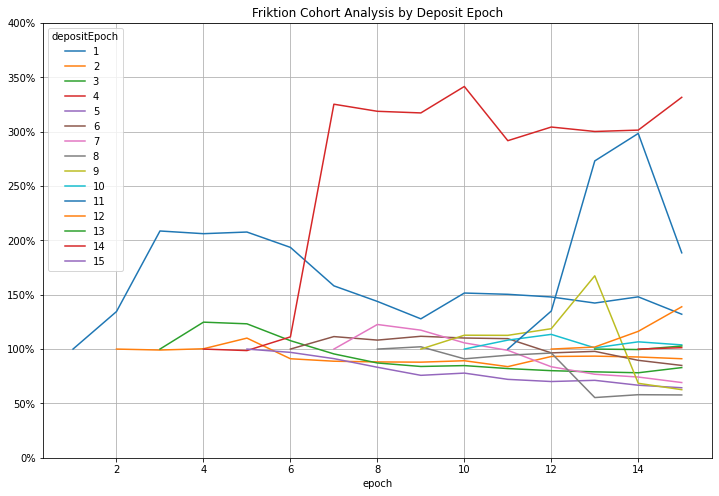

In [350]:
ax = plt.figure().gca()
cohorts_final.unstack(1)["retention"].T.plot(figsize=(12, 8), grid=True, ax=ax)
plt.ylim([0, 4])

plt.title("Friktion Cohort Analysis by Deposit Epoch")
ax.yaxis.set_major_formatter(formatter_percents)

# RETAIL

In [351]:
retail["depositEpoch"] = retail.groupby("userAddress")["epoch"].transform(lambda x: x.min())

cohorts = retail.groupby(["depositEpoch", "epoch"])[["net_tvl"]].sum().groupby("depositEpoch").cumsum()

normalize = pd.Series(cohorts.groupby("depositEpoch").net_tvl.first(), name="Initial Deposit")

cohorts_final = cohorts.join(normalize)

cohorts_final["retention"] = cohorts_final["net_tvl"]/cohorts_final["Initial Deposit"]

In [352]:
cohorts_final

net_tvl  Initial Deposit  retention
depositEpoch epoch                                          
1            1      1.027550e+07     1.027550e+07   1.000000
             2      1.382226e+07     1.027550e+07   1.345167
             3      2.143692e+07     1.027550e+07   2.086218
             4      2.118186e+07     1.027550e+07   2.061395
             5      2.133759e+07     1.027550e+07   2.076551
...                          ...              ...        ...
13           14     6.411444e+05     6.439131e+05   0.995700
             15     6.618936e+05     6.439131e+05   1.027924
14           14     1.844208e+06     1.844208e+06   1.000000
             15     1.872842e+06     1.844208e+06   1.015526
15           15     1.496169e+06     1.496169e+06   1.000000

[120 rows x 3 columns]

In [353]:
cohorts_final.unstack(1)["retention"]

epoch,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
depositEpoch,,,,,,,,,,,,,,,
1,1.0,1.345167,2.086218,2.061395,2.076551,1.935319,1.581433,1.438265,1.277965,1.515191,1.503377,1.478826,1.423045,1.480005,1.320080
2,NaN,1.000000,0.987783,0.999234,1.097298,0.906903,0.884107,0.872496,0.870214,0.883380,0.829027,0.919797,0.922957,0.918175,0.900649
3,NaN,NaN,1.000000,1.245558,1.230021,1.076088,0.955434,0.873671,0.841619,0.849641,0.822605,0.803337,0.792543,0.783811,0.831442
4,NaN,NaN,NaN,1.000000,0.985389,1.113880,3.250203,3.215397,3.199974,3.441097,2.944779,3.087521,3.046690,3.039931,3.352258
5,NaN,NaN,NaN,NaN,1.000000,0.970666,0.912941,0.833493,0.759333,0.779812,0.721136,0.701427,0.712460,0.667364,0.642714
6,NaN,NaN,NaN,NaN,NaN,1.000000,1.114538,1.082358,1.117730,1.101788,1.095988,0.965131,0.978403,0.896006,0.849009
7,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.226246,1.173124,1.056941,0.988373,0.828139,0.759403,0.740049,0.693075
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.020867,0.909213,0.943506,0.963422,0.554515,0.580972,0.578703
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.126636,1.131197,1.192066,1.676100,0.689362,0.630708


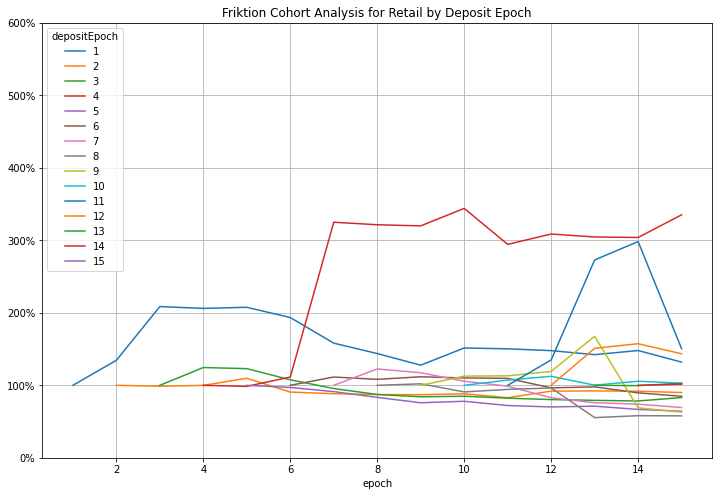

In [354]:
ax = plt.figure().gca()
cohorts_final.unstack(1)["retention"].T.plot(figsize=(12, 8), grid=True, ax=ax)
plt.ylim([0, 6])

plt.title("Friktion Cohort Analysis for Retail by Deposit Epoch")
ax.yaxis.set_major_formatter(formatter_percents)

# insti

In [304]:
insti["depositEpoch"] = insti.groupby("userAddress")["epoch"].transform(lambda x: x.min())

cohorts = insti.groupby(["depositEpoch", "epoch"])[["net_tvl"]].sum().groupby("depositEpoch").cumsum()

normalize = pd.Series(cohorts.groupby("depositEpoch").net_tvl.first(), name="Initial Deposit")

cohorts_final = cohorts.join(normalize)

cohorts_final["retention"] = cohorts_final["net_tvl"]/cohorts_final["Initial Deposit"]

/var/folders/t5/lm3g0brx0dsf0ymt1ldc8xdr0000gp/T/ipykernel_81302/2568014994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insti["depositEpoch"] = insti.groupby("userAddress")["epoch"].transform(lambda x: x.min())


In [305]:
cohorts_final.unstack(1)["retention"]

epoch,12,13,14,15
depositEpoch,,,,
12,1.0,NaN,1.145531,1.384675
13,NaN,1.0,0.545455,NaN
14,NaN,NaN,1.000000,NaN


In [306]:
insti

,txSignature,amount,instructionAction,instructionOrder,userAddress,timestamp,currencyName,currencyAddress,senderAddress,senderTokenMint,...,shareTokenMint,depositTokenSymbol,depositTokenCoingeckoId,userAction,symbol,price,amount_usdc,net_tvl,epoch,depositEpoch
474,2Go42nzfCu7VuMvsnT1tme4DhsqxWLNmacon6dS8JneLDb...,1.000000e+00,burn,0-0-2,CkbxaunPif9H3Zq24nyY87pKUe64GRteciPL5qXLUdzC,2022-03-21T10:32:10Z,NaN,BAyzqZuKUQ4k93Yfm3xp85SkAKtr4xghBsqZLBTZT14z,AuQHcJZhTd1dnXRrM78RomFiCvW6a9CqxxJ94Fp9h8b,HwcumVNT4QorS8x8vDpTo6ZYvLuQriW3tsxntzEcxxPd,...,BAyzqZuKUQ4k93Yfm3xp85SkAKtr4xghBsqZLBTZT14z,USDC,usd-coin,Withdraw,USDC,1.0,1.000000e+00,-1.000000e+00,14,13
5278,59QJCZNCKBauHkBcJHxkRYypfyTFyRtdvsAxxtAnofUH2a...,1.000000e+00,burn,0-0-3,CkbxaunPif9H3Zq24nyY87pKUe64GRteciPL5qXLUdzC,2022-03-20T14:27:57Z,NaN,BAyzqZuKUQ4k93Yfm3xp85SkAKtr4xghBsqZLBTZT14z,AuQHcJZhTd1dnXRrM78RomFiCvW6a9CqxxJ94Fp9h8b,HwcumVNT4QorS8x8vDpTo6ZYvLuQriW3tsxntzEcxxPd,...,BAyzqZuKUQ4k93Yfm3xp85SkAKtr4xghBsqZLBTZT14z,USDC,usd-coin,Withdraw,USDC,1.0,1.000000e+00,-1.000000e+00,14,13
5408,5EEaZHLb23h47aUkF41uU3fm5EUtnpFyfc8aJt3fB7pq25...,2.000000e+00,burn,0-0-3,WabxR2gcdMgovS6Uo5JD4Cv9me7uExRyaH4QDKrp64b,2022-03-24T09:08:32Z,NaN,BAyzqZuKUQ4k93Yfm3xp85SkAKtr4xghBsqZLBTZT14z,7M6TSEkRiXiYmpRCcCDSdJGTGxAPem2HBqjW4gLQ2KoE,3oFdWZeFRQriHCnjc5rmtyqVLqbpRBJugiEPqi5dPuRp,...,BAyzqZuKUQ4k93Yfm3xp85SkAKtr4xghBsqZLBTZT14z,USDC,usd-coin,Withdraw,USDC,1.0,2.000000e+00,-2.000000e+00,14,14
11600,2GR1JARZMSRP9wEtvVg5D1tbMptBayGuhCt6BuHjevvztx...,2.904146e+06,transfer,0-0,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,2022-03-07T10:10:46Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,8LrqyZvCsyBVFXDU9YbVAj6ukJ9tSKeXTmXNHWfZkGRF,...,Bikt7D3nMQmJSpxX7oczCDKgevrpWk3g4D3VhQZzqAT,USDC,usd-coin,Deposit,USDC,1.0,2.904146e+06,2.904146e+06,12,12
12301,2Pc4jNunQ6EEP9WRCuaBAjDnxhUCPdtjaeG8kASXFA8zbW...,1.000000e+00,transfer,0-0-0,CkbxaunPif9H3Zq24nyY87pKUe64GRteciPL5qXLUdzC,2022-03-12T10:38:30Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,AuQHcJZhTd1dnXRrM78RomFiCvW6a9CqxxJ94Fp9h8b,FdP14pVP2pdJdRLjE4y7dEXjZoYesxCBpN7VCAXcEvNb,...,BAyzqZuKUQ4k93Yfm3xp85SkAKtr4xghBsqZLBTZT14z,USDC,usd-coin,Deposit,USDC,1.0,1.000000e+00,1.000000e+00,13,13
12424,2QpmcXaPcM92jSR46XEXFVu2cp54J1zqGF8wGBdTdktFjk...,1.000000e+06,transfer,0-0,DWdU29KENzq87G1cm35XZTZpbBCvyNiTEiSpJgV1CWAf,2022-03-09T12:34:40Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,DWdU29KENzq87G1cm35XZTZpbBCvyNiTEiSpJgV1CWAf,7tETtFMNmdg1pZwoy6MxfHpZaUpry4JWwmtSJNLABond,...,J1TX6c1R6WykW2wonvrL6xA2g8vZ2FLDqDDF1mLYrMYK,USDC,usd-coin,Deposit,USDC,1.0,1.000000e+06,1.000000e+06,12,12
12429,2Qs6GVtGyotZQ9bKN1dvrMjasLCZsQx4KQV9wJCN9rwe82...,2.000000e-01,transfer,0-0-1,CkbxaunPif9H3Zq24nyY87pKUe64GRteciPL5qXLUdzC,2022-03-11T10:15:43Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,BZqHAEtN7snbmBD9feFKCSN9fQ9BXJyWQ8B35rnPcoaT,4Wz7SMFnYajxvABd9d1kHRMA8uVthHjS4LwNXAbviyef,...,THjfJ7GUeW6aMU6dzYYFVs5LnKNvmPzgk2wbh3bWagC,USDC,usd-coin,Deposit,USDC,1.0,2.000000e-01,2.000000e-01,13,13
14241,2iXm32JnkCwaVXBdygRUUXBMWtHnBAtfErBGJHBjmUC9N6...,1.000000e+06,transfer,0-0,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,2022-03-07T10:10:10Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,8LrqyZvCsyBVFXDU9YbVAj6ukJ9tSKeXTmXNHWfZkGRF,...,Bikt7D3nMQmJSpxX7oczCDKgevrpWk3g4D3VhQZzqAT,USDC,usd-coin,Deposit,USDC,1.0,1.000000e+06,1.000000e+06,12,12
15230,2tYn2KPx5dCwjR5t3WDFsY2maS6X4xZkdne98bbFC6FPdv...,3.683080e+05,transfer,0-0,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,2022-03-07T11:47:51Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,8LrqyZvCsyBVFXDU9YbVAj6ukJ9tSKeXTmXNHWfZkGRF,...,Bikt7D3nMQmJSpxX7oczCDKgevrpWk3g4D3VhQZzqAT,USDC,usd-coin,Deposit,USDC,1.0,3.683080e+05,3.683080e+05,12,12
15701,2y7w7ZUXjW34ApPSTAt39ezvzh8SzV4NJCphq1v9upDvGq...,2.000000e+00,transfer,0-0-1,WabxR2gcdMgovS6Uo5JD4Cv9me7uExRyaH4QDKrp64

# USER ADDRESS

In [393]:
retail.groupby("userAddress").net_tvl.sum().sort_values()[::-1].head(12).astype('int')

userAddress
5XgStSeDe22PVKojnuHaoboNGiJxgeszhLHsQYAgEBvs    18426091
FrrrZWDn7pCMiGoh35PVZbP8uV2n5nFFJx3uFuyKty2R    18327782
EcH12jxhrbhF6qHqRzWpZ8rZU3TjG3sX6F67zP61oDJG    10194000
7ts1w2Wjg6W9uL8rBfpdQSC7AFDEJeJ2aTE2SEBRHgwJ     3595238
3WGbVryXj7e2u7S1NEghSQbVB6PGZdCXBCoPwRuqUGZ1     2664495
CyAH9f9awBcfuZqHzwwEs4uJBLEG33S743jxnQX1KcZ6     2043837
GFpNdXho1pkJFn1xiH3nXKLY5LqUq5T27b9ZY8dKkNRg     1490196
GNisgcTZZ2WS5PFAEkVUbFso3wNe22cjhmZiEjGcqeHD     1342555
46NAjBDQZMQ3LW6kofZkYug2kLjDeiWW6ewUFAAMsB1S     1257077
BQfguZpr4hje4irm9xkcp7yrrKhWgCMCfEB51r3Ecrhg     1204977
3GYPiqCrAXkhH8xcRi8jJTLhdsXkyJS52qtHqbWGNeoR     1050345
C3bc3VVWoazK29ziUrZNUPraSKxZkfT88wVaDHdc7bnt     1045506
Name: net_tvl, dtype: int64

In [394]:
powerusers = retail.groupby("userAddress").net_tvl.sum().sort_values()[::-1].head(12).astype('int').index

In [395]:
retail.groupby("userAddress").net_tvl.sum().sort_values()[::-1][12:].sum()

56320829.55189401

In [397]:
retail.loc[retail.userAddress.isin(powerusers)].groupby("globalId").net_tvl.sum().astype('int').sort_values()[::-1]

globalId
mainnet_income_call_srm         14767171
mainnet_income_call_btc         11497532
mainnet_income_call_sol         10901973
mainnet_income_call_marinade     6415055
mainnet_income_call_ftt          5358271
mainnet_income_put_sol           4984524
mainnet_income_call_luna         2188844
mainnet_income_call_socean       2113702
mainnet_income_put_sol_high      1540712
mainnet_income_put_btc           1205095
mainnet_income_call_eth           852757
mainnet_income_call_mngo          259819
mainnet_income_put_mngo           200000
mainnet_income_put_luna           199979
mainnet_income_call_sbr           106663
mainnet_income_put_eth             50000
Name: net_tvl, dtype: int64

<AxesSubplot:>

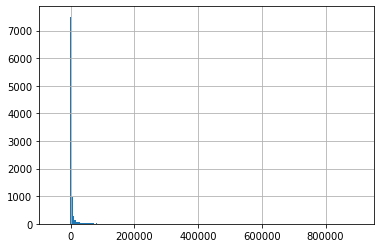

In [398]:
retail.loc[~retail.userAddress.isin(powerusers)].groupby("userAddress").net_tvl.sum().hist(bins=200)

In [439]:
hist=retail.groupby("userAddress").net_tvl.sum()

qq = pd.DataFrame(hist.quantile(np.linspace(.1, 1, 99, 0))).reset_index()
qq.columns=["percentile", "tvl"]
qq

,percentile,tvl
0,0.100000,1.675047
1,0.109091,2.481035
2,0.118182,3.106158
3,0.127273,4.014592
4,0.136364,4.914385
...,...,...
94,0.954545,21160.306417
95,0.963636,28493.967172
96,0.972727,42011.827882
97,0.981818,67440.790227


Text(0.5, 1.0, 'Friktion TVL per Wallet \n Retail Cumulative Percentage Distribution')

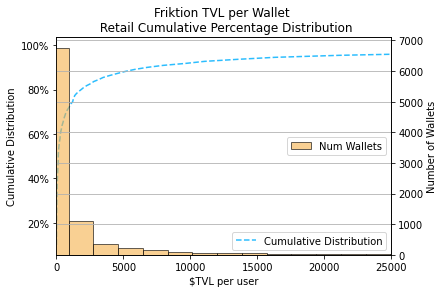

In [440]:
ax = plt.figure().gca()
ax2=ax.twinx()
ax.plot(qq.tvl, qq.percentile, color=CB91_Blue, linestyle='dashed', label="Cumulative Distribution")
plt.grid(True)
ax.set_xlim([0, 25000])
hist.hist(bins=10000, ax=ax2, edgecolor='black', color=CB91_Amber, alpha=0.6, label="Num Wallets")
ax.yaxis.set_major_formatter(formatter_percents)

ax.set_xlabel("$TVL per user")
ax.set_ylabel("Cumulative Distribution")
ax2.set_ylabel("Number of Wallets")

ax.legend(loc='lower right')
ax2.legend(loc='center right')
ax.set_title("Friktion TVL per Wallet \n Retail Cumulative Percentage Distribution")

In [433]:
hist=insti.groupby("userAddress").net_tvl.sum()

qq = pd.DataFrame(hist.quantile(np.linspace(.1, 1, 99, 0))).reset_index()
qq.columns=["percentile", "tvl"]
qq

,percentile,tvl
0,0.100000,3.000008e+05
1,0.109091,3.272735e+05
2,0.118182,3.545462e+05
3,0.127273,3.818189e+05
4,0.136364,4.090916e+05
...,...,...
94,0.954545,1.242719e+07
95,0.963636,1.278804e+07
96,0.972727,1.314890e+07
97,0.981818,1.350975e+07


Text(0.5, 1.0, 'Friktion TVL per Wallet\n Circuits Cumulative Percentage Distribution')

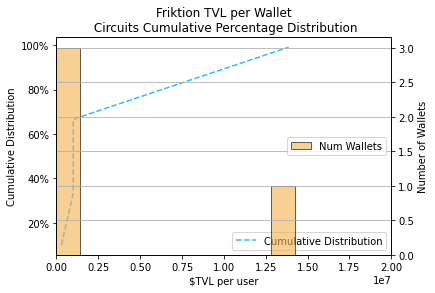

In [438]:
ax = plt.figure().gca()
ax2=ax.twinx()
ax.plot(qq.tvl, qq.percentile, color=CB91_Blue, linestyle='dashed', label="Cumulative Distribution")
plt.grid(True)
ax.set_xlim([0, 2e7])
hist.hist(bins=10, ax=ax2, edgecolor='black', color=CB91_Amber, alpha=0.6, label="Num Wallets")
ax.yaxis.set_major_formatter(formatter_percents)

ax.set_xlabel("$TVL per user")
ax.set_ylabel("Cumulative Distribution")
ax2.set_ylabel("Number of Wallets")

ax.legend(loc='lower right')
ax2.legend(loc='center right')
ax.set_title("Friktion TVL per Wallet\n Circuits Cumulative Percentage Distribution")